In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("../input/commonlitreadabilityprize/train.csv")

In [3]:
val_idx = np.arange(0, len(df), 5)
train_idx = [i for i in range(len(df)) if i not in val_idx]
df_train = df.iloc[train_idx].reset_index(drop=True)

In [20]:
def replace_stop_words(x):
    x = x.replace(".", " . ")
    x = x.replace(",", " , ")
    x = x.replace("!", " ! ")
    x = x.replace("?", " ? ")
    x = x.replace("\n", " \n ")
    x = x.replace(")", " ) ")
    x = x.replace("(", " ( ")
    x = x.replace('"', ' " ')
    x = x.replace(";", " ; ")

    x = x.replace("  ", " ")
    x = x.replace("  ", " ")
    return x

In [21]:
word_dict = {}
total_words = 0
for x in tqdm(df_train[["excerpt", "target"]].values):
# for x in tqdm(df[["excerpt", "target"]].values):
    excerpt = replace_stop_words(x[0])
    target = x[1]
    for word in set(excerpt.split(" ")):
        total_words += 1
        word = word
        if word not in word_dict:
            word_dict[word] = {
                "n": 1,
                "target": [target] 
            }
        else:
            word_dict[word]["n"] += 1
            word_dict[word]["target"].append(target)
    

<ipython-input-21-b44fa5c4a26a>:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for x in tqdm(df_train[["excerpt", "target"]].values):


In [22]:
for k in word_dict.keys():
    word_dict[k]["mean"] = np.array(word_dict[k]["target"]).mean()
    word_dict[k]["max"] = np.array(word_dict[k]["target"]).max()
    # word_dict[k]["25p"] = np.percentile(np.array(word_dict[k]["target"]), 25)
    # word_dict[k]["75p"] = np.percentile(np.array(word_dict[k]["target"]), 75)
    word_dict[k]["min"] = np.array(word_dict[k]["target"]).min()

In [23]:
dfs = []
for k in word_dict.keys():
    dfs.append({"word": k, 
                "mean": word_dict[k]["mean"], 
                "max": word_dict[k]["max"], 
                "min": word_dict[k]["min"], 
                # "25p": word_dict[k]["25p"], 
                # "75p": word_dict[k]["75p"], 
                "n": word_dict[k]["n"]})

In [24]:
dfs = pd.DataFrame(dfs)

In [25]:
target_mean = df_train["target"].mean()

In [26]:
def bayse_mean(n, mean, threshold=300):
    if n > threshold:
        return mean
    else:
        return (target_mean * (threshold - n) + mean * n) / threshold
    
dfs["bayse_mean"] = [bayse_mean(x[0], x[1]) for x in dfs[["n", "mean"]].values]

In [33]:
np.array([x for x in dfs.sort_values("bayse_mean").tail(500)["word"].values if x not in ["!", "?", "(", ")", "'", '"', ";", ".", ","]])

array(['Long', 'Look', 'chickens', 'ready', "o'clock", 'sing', 'king',
       'shop', 'rain', 'dogs', 'journey', 'remember', 'Tom', 'smell',
       'animal', 'scared', 'harm', 'gift', 'seated', 'feathers', 'Alice',
       'exclaimed', 'drink', 'made', 'sang', 'wall', 'move', 'brother',
       'humans', 'Many', 'jump', 'slowly', 'played', 'doctors', 'bushes',
       'plenty', 'hands', 'tied', 'hide', 'Another', 'All', 'taking',
       'picked', 'others', 'woke', 'quickly', 'yellow', 'fairy', 'deep',
       'flying', 'build', 'became', 'everyone', 'maybe', 'swim',
       'falling', 'quietly', 'lovely', 'we', 'fish', 'grabbed', 'man',
       'leaves', 'cook', 'call', 'agreed', 'sunny', 'seen', 'song',
       'Imagine', 'few', 'Jack', 'flowers', 'Maybe', 'basket', 'really',
       'together', 'takes', 'top', 'actually', 'even', 'example',
       'yourself', 'fear', 'cells', 'worried', 'forest', 'start', 'idea',
       'open', 'also', 'forgot', 'happens', 'bank', 'arm', 'not',
       'talke

In [28]:
dfs.sort_values("bayse_mean").tail(10)

,word,mean,max,min,n,bayse_mean
75,she,-0.483072,1.597870,-2.934846,445,-0.483072
116,go,-0.457383,1.541672,-3.164212,295,-0.465702
62,you,-0.452549,1.711390,-3.223444,564,-0.452549
405,get,-0.374841,1.541672,-3.668360,263,-0.446587
99,She,-0.347463,1.597870,-2.654974,256,-0.436798
65,said,-0.419919,1.465055,-3.403930,477,-0.419919
111,?,-0.407646,1.711390,-3.415781,463,-0.407646
104,!,-0.400286,1.597870,-3.415781,498,-0.400286
171,went,-0.396441,1.583847,-3.229761,336,-0.396441
301,One,-0.302631,1.711390,-2.913002,259,-0.392001


In [214]:
difficulty_dict = dfs.set_index("word")["bayse_mean"]

In [215]:
difficulties = []
for excerpt in df["excerpt"].values:
    excerpt = replace_stop_words(excerpt)
    ary = []
    for word in excerpt.split(" "):
        if word in difficulty_dict:
            ary.append(difficulty_dict[word])
        else:
            ary.append(target_mean)
    difficulties.append(ary)

In [216]:
df["diff"] = difficulties

In [217]:
df["mean"] = [np.mean(x) for x in df["diff"].values]
df["len"] = [len(x) for x in df["diff"].values]
for i in range(0, 100, 10):
    df[f"percentile{i}"] = [np.percentile(x, i) for x in df["diff"].values]

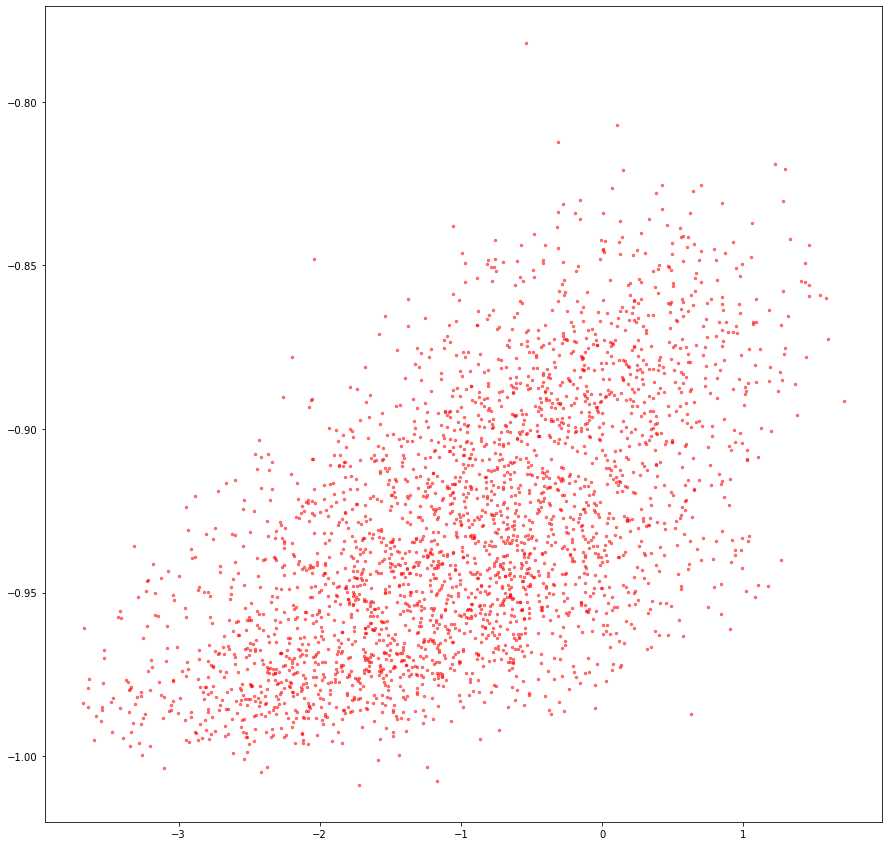

In [218]:

plt.figure(figsize=(15, 15))
plt.scatter(df["target"].values, df["mean"].values, s=6, alpha=0.5, color="red")

In [219]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.linear_model import Ridge


In [273]:

model = SVR(C=10000, epsilon=0.1)
# model = RandomForestRegressor(n_estimators=100)

In [274]:
df.columns

Index(['id', 'url_legal', 'license', 'excerpt', 'target', 'standard_error',
       'diff', 'mean', 'len', 'percentile0', 'percentile10', 'percentile20',
       'percentile30', 'percentile40', 'percentile50', 'percentile60',
       'percentile70', 'percentile80', 'percentile90'],
      dtype='object')

In [275]:
model.fit(df.iloc[train_idx].drop(["id", "url_legal", "license", "excerpt", "target", "diff", "standard_error"], axis=1).values,
          df.iloc[train_idx]["target"].values)

SVR(C=10000)

In [276]:
target = df.iloc[val_idx]["target"].values
pred = model.predict(df.iloc[val_idx].drop(["id", "url_legal", "license", "excerpt", "target", "diff", "standard_error"], axis=1).values)

In [277]:
rmse = np.sqrt(1 / len(pred) * ((target - pred)**2).sum())
print(rmse)

0.8251422442091497


In [278]:
pred

array([-1.33668347e+00, -1.17394972e+00, -1.52418219e+00, -4.00371466e-01,
       -8.25737148e-02, -7.08430400e-01, -5.29736667e-01,  4.32756857e-02,
        3.71165128e-01, -4.44930616e-01, -7.36410584e-01,  1.43547533e-01,
       -3.73311744e-01, -4.01662933e-02, -7.22869769e-01, -1.15862675e+00,
        2.45617132e-01, -8.84633477e-01, -1.07855368e+00, -8.12138391e-01,
       -1.05026861e+00, -3.27395124e-01,  1.34713454e-01, -8.15996805e-01,
       -1.14179482e+00, -4.27997237e-01, -1.22653334e+00, -1.24088041e+00,
       -3.36796020e-01, -3.89151219e-01, -8.03815571e-01, -5.58788726e-01,
       -7.01337426e-01, -5.13435324e-01, -1.21880480e-01, -9.79519611e-01,
       -1.02114840e+00, -5.56581794e-01, -6.20195169e-01, -3.95097008e-01,
       -2.56963409e-01, -1.23983374e+00, -7.52222524e-01, -2.10555325e-01,
       -1.59487987e+00, -3.55352077e-02, -1.02601593e+00, -7.47552259e-01,
        5.74203781e-01,  4.82617062e-02, -1.59213867e+00, -1.60845066e+00,
       -2.02310976e+00, -

In [279]:
df_exp007 = pd.read_csv("../output/exp007/20210531021845/val_fold0_best.csv")

In [280]:
for ratio in np.arange(0, 1, 0.01):
    pred_ensemble = pred * ratio + df_exp007["pred"].values * (1 - ratio)
    rmse = np.sqrt(1 / len(pred_ensemble) * ((target - pred_ensemble)**2).sum())
    print(f"ratio={ratio}: rmse={np.round(rmse, 4)}")

ratio=0.0: rmse=0.4952
ratio=0.01: rmse=0.4945
ratio=0.02: rmse=0.494
ratio=0.03: rmse=0.4936
ratio=0.04: rmse=0.4933
ratio=0.05: rmse=0.4931
ratio=0.06: rmse=0.493
ratio=0.07: rmse=0.493
ratio=0.08: rmse=0.4931
ratio=0.09: rmse=0.4933
ratio=0.1: rmse=0.4936
ratio=0.11: rmse=0.494
ratio=0.12: rmse=0.4945
ratio=0.13: rmse=0.4951
ratio=0.14: rmse=0.4958
ratio=0.15: rmse=0.4966
ratio=0.16: rmse=0.4975
ratio=0.17: rmse=0.4985
ratio=0.18: rmse=0.4996
ratio=0.19: rmse=0.5008
ratio=0.2: rmse=0.5021
ratio=0.21: rmse=0.5034
ratio=0.22: rmse=0.5049
ratio=0.23: rmse=0.5065
ratio=0.24: rmse=0.5082
ratio=0.25: rmse=0.5099
ratio=0.26: rmse=0.5118
ratio=0.27: rmse=0.5138
ratio=0.28: rmse=0.5158
ratio=0.29: rmse=0.5179
ratio=0.3: rmse=0.5201
ratio=0.31: rmse=0.5224
ratio=0.32: rmse=0.5248
ratio=0.33: rmse=0.5273
ratio=0.34: rmse=0.5299
ratio=0.35000000000000003: rmse=0.5325
ratio=0.36: rmse=0.5352
ratio=0.37: rmse=0.538
ratio=0.38: rmse=0.5409
ratio=0.39: rmse=0.5438
ratio=0.4: rmse=0.5469
ratio=0.410